# Lab 1: Optimizing Generative AI Workloads with Embedded ARM Processors

## Introduction

Welcome to the **Optimizing Generative AI Workloads with Embedded ARM Processors** lab! In this hands-on session, you will explore how ARMv8-A advanced vector processing capabilities can significantly accelerate computationally intensive tasks commonly found in artificial intelligence (AI) applications. By the end of this lab, you will gain a deep understanding of how low-level optimizations can enhance performance and how to leverage these optimizations within high-level AI frameworks like PyTorch.

**Requirements**: To complete this lab, you will need an ARMv8-A 64-bit system running a Linux-based operating system, such as a Raspberry Pi 4 or 5. The lab has been thoroughly tested on the Raspberry Pi 5 for compatibility and performance.

### **Why ARM Vector Instructions?**

ARM processors are ubiquitous in modern computing, powering everything from smartphones to edge devices and increasingly, servers and supercomputers. Their architecture is designed for energy efficiency and performance, making them ideal for deploying AI models in diverse environments. One of the key features that enable ARM processors to excel in AI workloads is their support for **vector instructions**, such as NEON and i8mm, which allow for parallel processing of multiple data points in a single instruction cycle. ARMv8-A is a member of the ARM architecture family, representing the 8th generation of ARM's advanced architecture with a focus on 64-bit computing, high performance, and scalable designs. It builds upon the energy-efficient foundation of earlier ARM architectures while introducing advanced features such as support for AArch64 (the 64-bit instruction set), enhanced vector processing capabilities, and improved cryptographic extensions. ARMv8-A is widely adopted in devices a range of mobile and embedded device including the **raspberry pi 4/5**

### **Lab Objectives**

The objectives of this lab are as follows: 

1. **Matrix Multiplication Optimization**:
   - Analyze three C-based matrix multiplication implementations (`naive`, `fp32_neon`, and `int8_neon`) to understand their performance differences.
   - Utilize ARMv8's NEON vector processing capability to accelerate matrix multiplications. The fundamental operation of AI workloads. 

2. **Benchmark PyTorch Operations**:
   - Measure the performance of PyTorch's matrix multiplication operations in different precisions. 
   - Examine the generated assembly code to identify how pytorch accelerates matrix multiplications

3. **Run Inference on a Language Model**:
   - Load and run inference on the state-of-the-art small language model, Llama3.2-1B.
   - Explore its computational graph to understand the underlying operations.

4. **Eager vs. Graph Execution**:
   - Compare PyTorch's Eager mode and Graph Execution.
   - Use `torch.compile` to minimize overhead and improve runtime performance.

5. **Apply Integer Quantization**:
   - Learn how integer quantization can reduce model size and accelerate inference.
   - Implement and evaluate quantization on matrix multiplication operations.
   - Apply Integer Quantization to Lamma3.2-1B and record it's latency speed ups and memory reductions. 



### **What You Will Learn**

- **Low-Level Optimizations**: Understand how ARM's NEON SIMD instructions can accelerate matrix computations.
- **Performance Benchmarking**: Develop skills to benchmark operations effectively and analyze performance trade-offs.
- **Framework Integration**: Explore how low-level optimizations can complement high-level frameworks like PyTorch.
- **Quantization Techniques**: Learn to implement quantization for efficient AI workloads on resource-constrained devices.

### **Prerequisites**

To follow this lab, you should have a basic understanding of:

- **C Programming**: Familiarity with C syntax and basic memory management.
- **Python Programming**: Experience writing and running Python scripts.
- **Matrix Operations**: A general understanding of matrix multiplication

### **Getting Started**

This lab begins with an exploration of matrix multiplication operators, the core computational components of AI workloads. Understanding and optimizing these operations can significantly enhance the inference performance of generative AI (GenAI) models. In this section, we will implement and compare three matrix multiplication approaches. While they are mathematically identical, their differing implementations result in vastly different performance outcomes. We will implement: 

1. **Naive Kernel (`src/c/kernels/naive.c`)**  
   - A simple, baseline implementation of the matrix multiplication to provide a reference point for performance.

2. **FP32 NEON Kernel (`src/c/kernels/fp32_neon.c`)**  
   - A matrix multiplication optimized for single-precision floating-point operations using ARM NEON SIMD instructions to leverage vectorized computation.

3. **INT8 NEON Kernel (`src/c/kernels/int8_neon.c`)**  
   - A integer matrix multiplication tailored for 8-bit operations, utilizing NEON SIMD to maximize throughput for lower-precision workloads.

By analyzing these implementations, you will gain insight into the performance trade-offs and benefits of hardware-specific optimizations that ARM can offer.

### **Mathematics of Matrix Multiplication and Its Importance in Generative AI Models**

#### **Basic Mathematics of Matrix Multiplication**

Matrix multiplication is a fundamental operation in linear algebra with wide-ranging applications in computer science, engineering, and especially in machine learning and AI. Given two matrices **A** and **B**, the product **C = A × B** is defined only if the number of columns in **A** matches the number of rows in **B**.

Mathematically, if **A** is an *m × n* matrix and **B** is an *n × p* matrix, then their product **C** will be an *m × p* matrix. The element at position *(i, j)* in matrix **C** is computed as:

$$C_{i,j} = \sum_{k=1}^{n} A_{i,k} \times B_{k,j}$$

**Example:**

Consider matrices **A** (2×3) and **B** (3×2):

$$
\mathbf{A} = \begin{bmatrix}
a_{11} & a_{12} & a_{13} \\
a_{21} & a_{22} & a_{23}
\end{bmatrix},
\quad
\mathbf{B} = \begin{bmatrix}
b_{11} & b_{12} \\
b_{21} & b_{22} \\
b_{31} & b_{32}
\end{bmatrix}
$$

Their product **C = A × B** (2×2) is:

$$
\mathbf{C} = \begin{bmatrix}
c_{11} & c_{12} \\
c_{21} & c_{22}
\end{bmatrix}
$$

where:

$$
\begin{align*}
c_{11} &= a_{11}b_{11} + a_{12}b_{21} + a_{13}b_{31} \\
c_{12} &= a_{11}b_{12} + a_{12}b_{22} + a_{13}b_{32} \\
c_{21} &= a_{21}b_{11} + a_{22}b_{21} + a_{23}b_{31} \\
c_{22} &= a_{21}b_{12} + a_{22}b_{22} + a_{23}b_{32}
\end{align*}
$$

#### **Computational Complexity**

The naive matrix multiplication algorithm has a time complexity of **O(n³)**, which becomes computationally expensive for large matrices. Optimizations, such as those leveraging vector instructions, aim to reduce the constant factors and improve cache utilization, thereby enhancing performance without altering the theoretical complexity.


<br><br><br>

### **Implementation of Naive Matrix Multiplication Kernel**

The naive implementation of matrix multiplication directly follows the mathematical definition. It uses three nested loops to compute the dot product of rows from matrix **A** and columns from matrix **B** for every element in the resulting matrix **C**. This is the most straightforward and intuitive approach but is computationally expensive due to its **O(n³)** time complexity.

#### **Code Explanation**

1. **Inputs**:
   - **A**, **B**: Flattened 2D matrices (stored as 1D arrays in row-major order) to be multiplied.
   - **C**: Flattened 2D matrix (1D array, also in row-major) to store the result.
   - **N**: Size of the square matrices (number of rows/columns).

2. **Procedure**:
   - The outer two loops iterate over the rows **i** and columns **j** of the resulting matrix **C**.
   - The innermost loop calculates the dot product for each element **C[i, j]** by summing the product of corresponding elements from row **i** of **A** and column **j** of **B**.

3. **Performance**:
   - This naive implementation is simple, performing one operation at a time but does not leverage advanced optimization techniques, such as blocking, vectorization, or parallelism.

#### **Naive Kernel Implementation**



In [1]:
!mkdir src/c/kernels

mkdir: cannot create directory ‘src/c/kernels’: File exists


In [2]:
%%writefile src/c/kernels/naive.c

#include <stdio.h>
#include <stdlib.h>
#include <time.h>

void matrix_multiply_naive(float* A, float* B, float* C, int N) {
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            C[i * N + j] = 0;
            for (int k = 0; k < N; k++) {
                C[i * N + j] += A[i * N + k] * B[k * N + j];
            }
        }
    }
}

Overwriting src/c/kernels/naive.c


### **Introduction to NEON SIMD Instructions**

NEON (ARM Advanced SIMD) is a set of SIMD (Single Instruction, Multiple Data) instructions designed to accelerate data-parallel operations on ARM processors. By leveraging NEON, computations on matrices, such as matrix multiplication, can be vectorized to process multiple data points simultaneously, thereby reducing execution time and increasing throughput.

#### **FP32 Matrix Multiplication Using NEON Instructions**

1. **Vectorized Processing**:
   - In this implementation, the function processes four `float32` elements at a time, utilizing NEON's 128-bit registers (`float32x4_t`).
   - The accumulation is performed using fused multiply-add operations, which minimize intermediate memory accesses.

2. **Key NEON Instructions Used**:
   - **`vld1q_f32`**: Loads four 32-bit floating-point elements into a vector register.
   - **`vmlaq_f32`**: Performs a fused multiply-add operation on vectors.
     

3. **Reduction Step**:
   - The vector accumulator is reduced into a scalar using:
     - **`vadd_f32`**: Adds low and high parts of the vector.
     - **`vpadd_f32`**: Horizontally adds remaining elements for a final scalar result.
     - **`vget_lane_f32`**: Extracts a specific element (lane) from a vector, used here to retrieve the final scalar value from the result of `vpadd_f32`.
       
       
4. **Advantages Over Naive FP32 Implementation**:
   - **Efficient Memory Access**: The naive implementation loads a single value at a time from memory, which can result in significant memory latency. The NEON implementation processes four elements simultaneously, reducing memory fetch overhead.
   - **Reduced Loop Iterations**: By processing multiple elements in parallel, the NEON implementation reduces the number of loop iterations required in the inner loop, significantly improving performance for large matrices.
   - **Optimized Accumulation**: NEON's fused multiply-add (`vmlaq_f32`) performs multiplication and addition in a single instruction, minimizing intermediate storage and computation overhead, unlike the naive implementation, which performs these operations sequentially.
   - **Hardware Acceleration**: NEON leverages specialized SIMD hardware in the ARM processor, making it much faster than the general-purpose computation used in the naive implementation.

5. **Description**:
   - The function performs matrix multiplication for `float32` matrices by iterating over the rows and columns of the input matrices, processing four elements at a time in the inner loop. This approach uses NEON to accelerate the computation by leveraging SIMD parallelism.



In [3]:
%%writefile src/c/kernels/fp32_neon.c

#include <arm_neon.h>
#include <stdio.h>

void matmul_fp32_neon(float* A, float* B, float* C, int N) {
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            float32x4_t acc = vdupq_n_f32(0.0f); // Accumulator
            for (int k = 0; k < N; k += 4) { // Process 4 elements at a time
                float32x4_t a_vec = vld1q_f32(&A[i * N + k]); // Load row of A
                float32x4_t b_vec = vld1q_f32(&B[k * N + j]); // Load column of B
                acc = vmlaq_f32(acc, a_vec, b_vec); // Multiply-accumulate
            }
            // Reduce acc to a single value and store in C
            float32x2_t sum1 = vadd_f32(vget_low_f32(acc), vget_high_f32(acc));
            float sum = vget_lane_f32(vpadd_f32(sum1, sum1), 0);
            C[i * N + j] = sum;
        }
    }
}

Overwriting src/c/kernels/fp32_neon.c


### **Introduction to Quantized (INT8) Matrix Multiplication Using NEON SIMD**

Quantized matrix multiplication uses low-precision. In this case, 8-bit integer representations to reduce memory bandwidth, power consumption, and computational complexity. ARM processors with NEON (integer 8-bit matrix multiplication) instructions provide significant acceleration by increasing the level of vectorization and benefiting from the efficiency of integer arithmetic.

#### **INT8 Matrix Multiplication Using NEON Instructions**

1. **Increased Levels of Vectorization**:
   - The implementation processes eight `int8_t` elements at a time, leveraging the higher data packing density of 8-bit integers compared to `float32` (four elements at a time). This doubles the level of parallelism compared to the FP32 implementation.

2. **Key NEON Instructions Used**:
   - **`vld1_s8`**: Loads eight signed 8-bit integers into a vector register.
   - **`vmlal_s8`**: Multiplies two vectors of signed 8-bit integers and accumulates the results into 16-bit integers.

3. **Reduction Step**:
   - **`vaddvq_s16`**: Horizontally sums the elements of a 16-bit integer vector to produce a scalar result.

4. **Advantages Over FP32 Implementation**:
   - **Higher Vectorization**: Processes eight elements at a time versus four in the FP32 version.
   - **Integer Arithmetic**: Integer operations are inherently faster than floating-point operations on most hardware due to simpler hardware requirements.
   - **Lower Memory Usage**: `int8_t` data consumes four times less memory than `float32`, leading to reduced cache pressure and better memory bandwidth utilization.
   - **Energy Efficiency**: Integer computations typically consume less power, making this approach ideal for energy-constrained environments.

5. **Description**:
   - The function performs matrix multiplication for quantized `int8` matrices by iterating over the rows and columns of the input matrices. In the inner loop, eight elements are processed simultaneously using NEON SIMD instructions. The 16-bit intermediate results are accumulated, and the final reduction produces a 32-bit scalar result for each element of the output matrix.




In [4]:
%%writefile src/c/kernels/int8_neon.c

#include <arm_neon.h>
#include <stdio.h>

void matmul_int8_neon(int8_t* A, int8_t* B, int32_t* C, int N) {
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            int16x8_t acc = vdupq_n_s16(0); // Initialize 16-bit accumulator

            for (int k = 0; k < N; k += 8) { // Process 8 elements at a time
                // Load 8 int8 elements from row of A and column of B
                int8x8_t a_vec = vld1_s8(&A[i * N + k]);
                int8x8_t b_vec = vld1_s8(&B[k * N + j]);

                // Perform element-wise multiplication and accumulate
                acc = vmlal_s8(acc, a_vec, b_vec);
            }

            // Reduce the 16-bit accumulator into a 32-bit scalar
            int32_t sum = vaddvq_s16(acc); // Horizontally sum all elements in the vector
            C[i * N + j] = sum; // Store the result in C
        }
    }
}

Overwriting src/c/kernels/int8_neon.c


### **Compiling Each Kernel to Inspect Assembly Using GCC**

With the kernel implementations ready, we can compile them into assembly code to examine how the compiler leverages NEON hardware-level optimizations to enhance performance. This step provides insights into how SIMD instructions are utilized for accelerating computations, particularly for matrix operations.

#### **Steps to Compile Each Kernel**

To inspect the generated assembly code for each kernel, use the following GCC command:


In [5]:
!mkdir bin
!gcc -O0 -S -march=armv8-a+simd src/c/kernels/naive.c -o bin/naive.s
!gcc -O3 -S -march=armv8-a+simd src/c/kernels/fp32_neon.c -o bin/fp32_neon.s
!gcc -O3 -S -march=armv8-a+simd src/c/kernels/int8_neon.c -o bin/int8_neon.s

mkdir: cannot create directory ‘bin’: File exists


---
### 1. **Naive Implementation**
   - Uses scalar instructions exclusively, meaning each operation processes a single pair of data values at a time.
   - Relies on the following types of ARM assembly instructions:
     - **`ldr` (Load Register):** Loads a single value from memory into a register.
     - **`str` (Store Register):** Stores a single value from a register into memory.
     - **`mul` (Multiply):** Multiplies two values in registers.
     - **`add` (Add):** Adds two values in registers.
   - Does not utilize SIMD (Single Instruction Multiple Data) capabilities, which can process multiple data values simultaneously in a single instruction.
   - Experiences significant overhead in memory operations due to the frequent use of `ldr` and `str` instructions for each operation, as no batching or parallelism is applied.

#### Observations:
   - Computational units are underutilized because operations are performed serially, one at a time.
   - Memory bandwidth becomes a bottleneck as frequent loads and stores slow down processing.
   - Best suited for small matrices or architectures without support for vectorized operations.



In [6]:
!sed -n '34,50p' bin/naive.s

.L5:
	ldr	w1, [sp, 44]
	ldr	w0, [sp, 4]
	mul	w1, w1, w0
	ldr	w0, [sp, 40]
	add	w0, w1, w0
	sxtw	x0, w0
	lsl	x0, x0, 2
	ldr	x1, [sp, 8]
	add	x0, x1, x0
	ldr	s1, [x0]
	ldr	w1, [sp, 44]
	ldr	w0, [sp, 4]
	mul	w1, w1, w0
	ldr	w0, [sp, 36]
	add	w0, w1, w0
	sxtw	x0, w0


---
### 2. **NEON Vectorization**
   - Leverages NEON SIMD instructions to perform parallel computations on multiple data values simultaneously:
     - **`movi` (Move Immediate):** Initializes all elements of a NEON vector register to a specified immediate value (e.g., zero).
     - **`fmul` (Floating-Point Multiply):** Multiplies corresponding elements in two NEON vector registers.
     - **`fadd` (Floating-Point Add):** Adds corresponding elements in two NEON vector registers.
     - **`dup` (Duplicate):** Copies a scalar value into all elements of a vector register or duplicates one element of a vector across a scalar register.
     - **`faddp` (Floating-Point Add Pair):** Adds adjacent pairs of elements within a vector register, effectively reducing the vector size.
   - Processes 128-bit registers, enabling parallel computation of up to 4 single-precision floating-point numbers in a single instruction.
   - Utilizes optimized memory access patterns to minimize latency and bottlenecks.

#### Observations:
   - The extracted assembly demonstrates the use of NEON vector registers (e.g., `v0`, `v1`, `v2`) and instructions for efficient parallel floating-point computations.
   - While the exact addresses or register assignments may vary slightly due to compiler differences, the core operations and use of NEON SIMD instructions remain consistent.

***NOTE***
If the code block below does not show the exact instructions described above, you can open the `bin/fp32_neon.s` file to view the full assembly. Regardless of compiler variations, you should see similar operations (e.g., `movi`, `fmul`, `fadd`, `dup`, `faddp`) utilizing NEON vector registers to perform SIMD optimizations.

#### Example Assembly Output:
```assembly
movi	v1.4s, 0               // Initialize all elements of v1 to zeros
fmul	v0.4s, v0.4s, v2.4s   // Multiply corresponding elements of v0 and v2, store result in v0
fadd	v1.4s, v1.4s, v0.4s   // Add corresponding elements of v1 and v0, store result in v1
dup	d0, v1.d[1]            // Duplicate the second 64-bit element of v1 into scalar register d0
fadd	v0.2s, v0.2s, v1.2s   // Add the lower two elements of v0 and v1, store result in v0.2s
faddp	v0.2s, v0.2s, v0.2s   // Pairwise add elements of v0.2s, reducing it to one scalar



In [7]:
!grep -E '\bv[0-9]+(\.[a-z0-9]+)?\b' bin/fp32_neon.s

	movi	v1.4s, 0
	fmul	v0.4s, v0.4s, v2.4s
	fadd	v1.4s, v1.4s, v0.4s
	dup	d0, v1.d[1]
	fadd	v0.2s, v0.2s, v1.2s
	faddp	v0.2s, v0.2s, v0.2s


### 3. **NEON Vectorization (Integer8-based)**

This implementation leverages NEON SIMD instructions for efficient integer matrix multiplication. While it does **not** utilize i8mm-specific instructions, it achieves high performance with quantized data using the following NEON operations:

#### Key NEON Instructions Observed:
   - **`movi` (Move Immediate):** Initializes all elements of a NEON vector register to a specified immediate value, such as zero.
   - **`smlal` (Signed Multiply-Add Long):** Multiplies pairs of 8-bit integers from two vector registers, producing 16-bit results, and accumulates them into a 16-bit vector register.
   - **`addv` (Add Across Vector):** Horizontally sums all elements of a NEON vector register into a single scalar value.
   - **`smov` (Scalar Move):** Moves the lowest element from a NEON vector register into a scalar general-purpose register.

#### Characteristics:
   - Processes **8 `int8_t` elements at a time** due to NEON's 128-bit vector registers, allowing for significantly higher throughput compared to `float32` implementations.
   - Accumulates intermediate results in 16-bit registers (`int16`) to avoid overflow during the computation.
   - Reduces the final 16-bit vector to a scalar using a horizontal sum (`addv`) followed by moving the scalar value to a general-purpose register (`smov`).

#### Observations:
   - **Performance Benefits**:
     - Processes multiple `int8` elements per instruction, maximizing the benefits of vectorization.
     - Smaller data types (`int8` vs. `float32`) reduce memory bandwidth requirements and improve efficiency.
   - **Precision Limitations**:
     - Integer arithmetic lacks the precision of floating-point operations, making it best suited for quantized workloads like neural network inference where reduced precision is acceptable.
   - **Applications**:
     - Ideal for embedded systems, mobile devices, and other environments requiring low-power, memory-efficient AI inference.

***NOTE***  
If the code block below does not show the exact instructions described above, you can open the `bin/int8_neon.s` file to view the assembly. Regardless of compiler or system variations, the assembly will use similar operations (e.g., `movi`, `smlal`, `addv`, `smov`) to optimize the `int8` matrix multiplication using NEON SIMD instructions.

#### Example Assembly Output:
```assembly
movi	v0.4s, 0               // Initialize v0 to zeros
smlal	v0.8h, v2.8b, v1.8b   // Multiply 8-bit integers from v2 and v1, accumulate into 16-bit vector v0
addv	h0, v0.8h             // Horizontally sum all elements in v0.8h into scalar h0
smov	w0, v0.h[0]           // Move the lowest 16-bit value from v0 to scalar register w0


In [8]:
!grep -E '\bv[0-9]+(\.[a-z0-9]+)?\b' bin/int8_neon.s


	movi	v0.4s, 0
	smlal	v0.8h, v2.8b, v1.8b
	addv	h0, v0.8h
	smov	w0, v0.h[0]


### **BenchMarking**

Lets now compute the latency of results of these three operators across different matrix sizes top emprically measure their differences. We can set the matrix sizes used in the benchmark by writing them out to **src/c/sizes.c** as seen below. Feel free to adapt the sizes yourself to see how it can effect latency, Bear in mind however large matrix multiplications are compute intensive operations!

***Note***
This code is tested on raspberry pi 5 (Cortex-A76) with matmul size of 1024 can take upto 45s. 

In [9]:
%%writefile src/c/sizes.c

int sizes[] = {32, 64, 128, 256, 512};

Overwriting src/c/sizes.c


**Compile and record latency with the naive implementation**

In [10]:
# Compile the C code with optimization level 3 and NEON SIMD extensions, outputting the binary to bin/benchmark
!gcc -O0 src/c/benchmark_naive.c -o bin/benchmark_naive -march=armv8-a+simd -lm
!./bin/benchmark_naive

Naive Matrix Multiplication (Size 32): 0.000298 seconds
Naive Matrix Multiplication (Size 64): 0.002343 seconds
Naive Matrix Multiplication (Size 128): 0.019973 seconds
Naive Matrix Multiplication (Size 256): 0.116517 seconds
Naive Matrix Multiplication (Size 512): 1.438271 seconds


**Compile and record latency with the floating point SIMD implementation**

In [68]:
!gcc -O3 -ffast-math src/c/benchmark_fp32_neon.c -o bin/benchmark_fp32_neon -march=armv8-a+simd -lm
!./bin/benchmark_fp32_neon

FP32 NEON Matrix Multiplication (Size 32): 0.000008 seconds
FP32 NEON Matrix Multiplication (Size 64): 0.000059 seconds
FP32 NEON Matrix Multiplication (Size 128): 0.000462 seconds
FP32 NEON Matrix Multiplication (Size 256): 0.008002 seconds
FP32 NEON Matrix Multiplication (Size 512): 0.143779 seconds


**Compile and record latency with the integer-8 SIMD Impelmentation**

In [13]:
!gcc -O3 -ffast-math src/c/benchmark_int8_neon.c -o bin/benchmark_int8_neon -march=armv8-a+simd -lm
!./bin/benchmark_int8_neon


Int8 Neon Matrix Multiplication (Size 32): 0.000005 seconds
Int8 Neon Matrix Multiplication (Size 64): 0.000035 seconds
Int8 Neon Matrix Multiplication (Size 128): 0.000247 seconds
Int8 Neon Matrix Multiplication (Size 256): 0.001876 seconds
Int8 Neon Matrix Multiplication (Size 512): 0.032232 seconds


## **Plot the results** 
Great, now the operators have been run, lets plot how there latency scales with matrix size. 

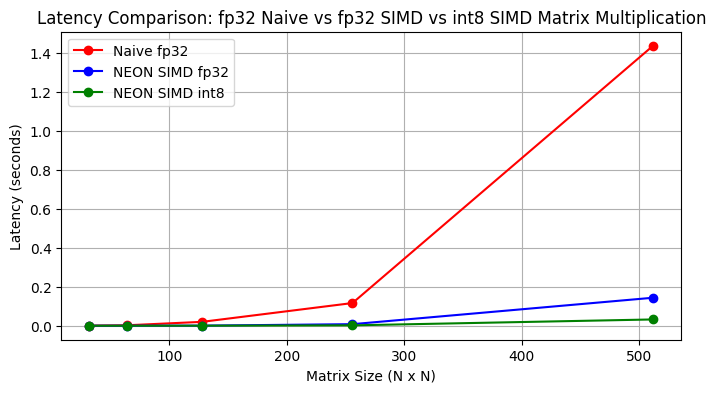

In [1]:
import matplotlib.pyplot as plt
import pandas as pd


# Load data from CSV files
naive_data = pd.read_csv('results/naive_latency_results.csv')
fp32_neon_data = pd.read_csv('results/fp32_neon_latency_results.csv')
int8_neon_data = pd.read_csv('results/int8_neon_latency_results.csv')

# Extract sizes and times
sizes = naive_data['Matrix Size']
naive_times = naive_data['Latency (seconds)']
fp32_neon_times = fp32_neon_data['Latency (seconds)']
int8_neon_times = int8_neon_data['Latency (seconds)']

plt.figure(figsize=(8, 4))

# Plotting the latency for each approach
plt.plot(sizes, naive_times, marker='o', linestyle='-', color='r', label='Naive fp32')
plt.plot(sizes, fp32_neon_times, marker='o', linestyle='-', color='b', label='NEON SIMD fp32')
plt.plot(sizes, int8_neon_times, marker='o', linestyle='-', color='g', label='NEON SIMD int8')

# Adding labels and title
plt.xlabel('Matrix Size (N x N)')
plt.ylabel('Latency (seconds)')
plt.title('Latency Comparison: fp32 Naive vs fp32 SIMD vs int8 SIMD Matrix Multiplication')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

As shown in the graph, the naive approach, which processes each matrix element individually, is the slowest. The SIMD floating-point implementation offers significant speedup, but the SIMD integer implementation is the fastest as it's the int8 lower bit-width allows a higher degree of parallelism. This highlights the advantage of using lower-precision operations in AI network forward passes for improved performance.

# **Pytorch**
Having explored how ARM's SIMD capabilities in C can accelerate AI workloads, we now transition to PyTorch which is a versatile, high-level framework that balances flexibility and ease of use. PyTorch streamlines AI model development by abstracting low-level operations, enabling developers to focus on model architecture and experimentation rather than intricate implementation details.

Unlike the manual coding required for SIMD operations in C, PyTorch offers built-in support for tensor computations and hardware acceleration. It automatically utilizes processor optimizations, including SIMD and ARM's NEON instructions, to enhance performance without requiring developers to write low-level code.

In the next section, we will examine how PyTorch utilizes the ARMv8-A's vectorization capability and benchmark Python-based matrix multiplication using both `int8` and `fp32` precision. Building on this foundation, we will implement and optimize the inference of a state-of-the-art small language model, **Llama 3.2-1B**, showcasing PyTorch's powerful capabilities for handling advanced AI workloads on ARMv8.

Let's start by checking the build configuration of our installed pytorch package. 

In [2]:
import torch
print(torch.__config__.show())


PyTorch built with:
  - GCC 10.2
  - C++ Version: 201703
  - Intel(R) MKL-DNN v3.5.3 (Git Hash 66f0cb9eb66affd2da3bf5f8d897376f04aae6af)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: NO AVX
  - Build settings: BLAS_INFO=open, BUILD_TYPE=Release, CXX_COMPILER=/opt/rh/devtoolset-10/root/usr/bin/c++, CXX_FLAGS=-ffunction-sections -fdata-sections -D_GLIBCXX_USE_CXX11_ABI=0 -fabi-version=11 -fvisibility-inlines-hidden -DUSE_PTHREADPOOL -DNDEBUG -DUSE_KINETO -DLIBKINETO_NOCUPTI -DLIBKINETO_NOROCTRACER -DLIBKINETO_NOXPUPTI=ON -DUSE_PYTORCH_QNNPACK -DUSE_XNNPACK -DSYMBOLICATE_MOBILE_DEBUG_HANDLE -O2 -fPIC -Wall -Wextra -Werror=return-type -Werror=non-virtual-dtor -Werror=bool-operation -Wnarrowing -Wno-missing-field-initializers -Wno-type-limits -Wno-array-bounds -Wno-unknown-pragmas -Wno-unused-parameter -Wno-strict-overflow -Wno-strict-aliasing -Wno-stringop-overflow -Wsuggest-override -Wno-psabi -Wno-err

In this output, you can see the build configuration for this version of PyTorch. Some key flags indicate how PyTorch is optimized for performance on the your device:

- **`USE_OPENMP=ON`**: This library is used to parallelize matrix multiplications across threads, providing speedups on the Raspberry Pi's quad-core processor.
- **`BLAS_INFO=ON`** BLAS (Basic Linear Algebra Subprograms) are used to perform efficient linear algebra on ARM utilizing vector processing. 
- **`USE_NNPACK=ON`**: A low-level library of operators that utilizes vectorized instructions on ARM processors to accelerate operations.
- **`USE_MKLDNN=ON`**: While primarily designed for x86 processors, this library also includes vectorized implementations of operators optimized for the AArch64 architecture, making it compatible with devices like the Raspberry Pi 4 and 5.

These build configurations show that PyTorch is equipped to take advantage of ARM's vectorization and multi-threading capabilities. 

Next, let's validate that PyTorch is successfully utilizing these low-level libraries to vectorize its tensor operations.

---

### **Analyzing PyTorch's Utilization of ARM Vector Processing**

To confirm PyTorch's use of ARM's vector processing capabilities, we will investigate its behavior under the hood by writing two simple scripts for matrix multiplication. These scripts replicate what we implemented in C earlier but leverage PyTorch's abstractions. 

The scripts will perform matrix multiplication using both 32-bit floating-point (`fp32`) and 8-bit integer (`int8`) precisions. PyTorch simplifies these operations by providing built-in functionality that abstracts away low-level details, enabling developers to focus on high-level design while still benefiting from hardware optimizations.


In [3]:
!mkdir src/python

mkdir: cannot create directory ‘src/python’: File exists


In [4]:
%%writefile src/python/fp_matmul.py

import torch
a = torch.randn(1024, 1024, dtype=torch.float32, requires_grad=False)
b = torch.randn(1024, 1024, dtype=torch.float32, requires_grad=False)
c = torch.mm(a, b)


Overwriting src/python/fp_matmul.py


In [5]:
%%writefile src/python/int8_matmul.py
import torch

# Generate random int8 tensors
a = torch.randint(-128, 128, size=(1024, 1024), dtype=torch.int8)
b = torch.randint(-128, 128, size=(1024, 1024), dtype=torch.int8)
c = torch.mm(a, b)

Overwriting src/python/int8_matmul.py


### **Using `perf` to Inspect Assembly**

The following code cells use the `perf` tool to extract the assembly instructions executed by the Python scripts above. By capturing this assembly, we can analyze whether the low-level libraries that `torch.mm` relies on for matrix multiplication are effectively utilizing ARM's vector processing capabilities, such as NEON instructions.

We will write the extracted assembly code to a text file for further analysis. This process allows us to verify if PyTorch's operations are optimized to leverage hardware acceleration on ARM-based systems.

**Note**: In the following code cells, a 10-second timeout is applied. This is sufficient to capture a representative sample of the assembly instructions. 


**Extract assembly for the floating point matmul**

In [6]:
import signal

def handler(signum, frame):
    raise TimeoutError("Execution timed out!")

signal.signal(signal.SIGALRM, handler)
signal.alarm(10)  # Set the alarm for 60 seconds

try:
    # Your long-running code here
    !rm -rf *perf*
    !rm -rf fp_matmul.txt
    !sudo perf record -e instructions:u -g $(which python) src/python/fp_matmul.py
    !sudo perf annotate > results/fp_matmul_instructions.txt
except TimeoutError as e:
    !rm -rf *perf*
    print("============================== Completed! ==============================")
finally:
    signal.alarm(0)  # Disable the alarm

[ perf record: Woken up 23 times to write data ]
[ perf record: Captured and wrote 5.843 MB perf.data (13457 samples) ]
============================== Completed! ==============================


**Extract assembly for the int8 matmul**

In [7]:
import signal

def handler(signum, frame):
    raise TimeoutError("Execution timed out!")

signal.signal(signal.SIGALRM, handler)
signal.alarm(10)  # Set the alarm for 60 seconds

try:
    # Your long-running code here
    !rm -rf *perf*
    !rm -rf int8_matmul.txt
    !sudo perf record -e instructions:u -g $(which python) src/python/int8_matmul.py
    !sudo perf annotate > results/int8_matmul_instructions.txt
except TimeoutError as e:
    !rm -rf *perf*
    print("============================== Completed! ==============================")
finally:
    signal.alarm(0)  # Disable the alarm

[ perf record: Woken up 25 times to write data ]
[ perf record: Captured and wrote 6.085 MB perf.data (13886 samples) ]
============================== Completed! ==============================


- Now lets have a look inside the instructions used by pytorch for the floating point matrix multiply script and print them below. We will search for vectorized instructions such as `fmul` and `fadd` to detect their presence and ensure they are using the vector registers,

In [8]:
!grep -m 20 -E '\bv[0-9]+(\.[a-z0-9]+)?\b' results/fp_matmul_instructions.txt

You should see printed out above some assembly instructions that the ARM processor will run. the structure of each line written out by `perf annotate` has the following format

***timestamp :    instruction_address: operation:   destination_registor, source_register1, source_register2***

The printout should show operations making use of the vector registers. Examples of operations you might see include.   

#### **Operation Definitions**
- **`fmul`**: Performs a floating-point multiplication operation between two operands.
- **`fmla`**: Performs a floating-point fused multiply-add operation, where the result of the multiplication is added to an accumulator in a single instruction.

- **Vector Registers**: Operands starting with a `v` (e.g., `v16.4s`, `v0.4s`, `v8.s[0]`) indicate that vector registers are being used. These registers contain multiple data lanes, enabling the instruction to process multiple elements simultaneously, thereby increasing throughput.
  - Example: `fmla v16.4s, v0.4s, v8.s[0]` performs the fused multiply-add operation on four single-precision floating-point elements in parallel (one for each lane of the vector register `v16`)..

By examining the register types (vector vs. scalar), it becomes clear whether the instruction leverages SIMD for parallel processing or operates in a scalar manner and therefore whether torch is uses ARM's NEON SIMD processing capabilities to accelerate the matrix muliply operation. 

***Note*** Should no vector registers show up in your instruction list above, please look inside the file results/fp_matmul_instructions.txt to identify any vector register utilization. 


In [86]:
!grep -m 20 -E '\bv[0-9]+(\.[a-z0-9]+)?\b' results/int8_matmul_instructions.txt

    0.00 :   3740150:        dup     v2.16b, w0
    0.00 :   3740160:        mla     v0.16b, v1.16b, v2.16b
    0.00 :   3740194:        dup     v1.8b, w0
    0.00 :   37401a8:        mla     v0.8b, v2.8b, v1.8b
    0.00 :   3740518:        movi    v0.4s, #0x0
    0.00 :   374053c:        mla     v0.16b, v2.16b, v1.16b
    0.00 :   3740548:        addv    b0, v0.16b
    0.00 :   3740554:        umov    w5, v0.b[0]
    0.00 :   3740594:        mul     v0.8b, v0.8b, v1.8b
    0.00 :   3740598:        addv    b0, v0.8b
    0.00 :   374059c:        umov    w12, v0.b[0]
    0.00 :   374082c:        dup     v2.16b, w0
    0.00 :   3740840:        mla     v0.16b, v1.16b, v2.16b
    0.00 :   3740878:        dup     v1.8b, w0
    0.00 :   374088c:        mla     v0.8b, v2.8b, v1.8b
    0.00 :   3740b34:        movi    v3.4s, #0x0
    0.00 :   3740b44:        mov     v22.16b, v3.16b
    0.00 :   3740b48:        mov     v21.16b, v3.16b
    0.00 :   3740b50:        mov     v9.16b, v3.16b
    0.00 

Examples of instructions you might see in the output above are: 
- **`dup`**: Duplicates the value of a scalar register (e.g., `w0`) into all lanes of a SIMD vector register (e.g., `v2.16b`). This allows the same value to be broadcast across multiple lanes for parallel processing.
- **`mla`**: Performs a fused multiply-accumulate operation. It multiplies corresponding elements from two SIMD vector registers and adds the results to the accumulator register. This operation is performed on all lanes in parallel.
- **`addv`**: Adds all elements in a SIMD vector register and stores the resulting sum in a scalar register. This is typically used for reduction operations to aggregate data from multiple lanes.
- **`umov`**: Extracts a specific lane from a SIMD vector register and moves it to a scalar register. This is useful for accessing individual elements after SIMD processing.

These presence of these instructions shown above indicate that torch is utilizing ARMS SIMD capabilities. 

***Note*** Should no vector registers show up in the instruction list above, please look inside the file results/fp_matmul_instructions.txt to identify any vector register utilization. 

## **Benchmarking Pytorch Linear Layer**
Great. Now you have verified that pytorch is utilizing the vector processing capability of ARM by defualt, we can benchmark it's operations. Specifically, let's benchmark the floating point and integer precision operations. Just like our above kernel examples writte in c. We should see a measurable latency reduction when processing in int8 precision vs fp32.

**Write a latency measuring function**

In [9]:
import time 
import numpy as np
torch.set_num_threads(1)

def benchmark(inputs, func, num_runs=10): 
    times = []
    for _ in range(3): 
        func(inputs)

    for _ in range(num_runs): 
        st = time.time()
        func(inputs)
        times.append(time.time() - st)

    return np.mean(times)

**Once again specify the size of matrices to evaluate**

feel free to adjust the matrix sizes to identify how much computation large matrix multiply's require!

In [10]:
import torch 
sizes = [32, 64, 128, 256, 512, 1024]

**Record Latencies for a Full Precision Linear Layer**  
The linear layer is a fundamental building block of generative AI models like transformers, performing dense matrix multiplications at its core. Given input $ X \in \mathbb{R}^{m \times n} $ and weights $ W \in \mathbb{R}^{n \times p} $, the output $ Y \in \mathbb{R}^{m \times p} $ is computed as $ Y = XW + b $, where $ b $ is an optional bias term. Measuring the latency of these FP32 matrix multiplications provides a baseline for assessing performance and comparing with optimized or quantized implementations.

In [11]:
import torch 
import torch.nn as nn

float_times = []
for size in sizes:
    # floating point measurements 
    x = torch.randn(size, size, dtype=torch.float32, requires_grad=False)
    linear = nn.Linear(size, size, bias=False)
    float_times.append(benchmark(x, linear))

**Record Latencies for an INT8 Quantized Linear Layer**  
In a quantized linear layer, the computation $ Y = XW + b $ is performed using INT8 precision for the operands $ X $ (input) and $ W $ (weights), while optionally adding a bias $ b $ in a higher precision (e.g., INT32 or FP32) to preserve accuracy. Quantization maps the original floating-point values to 8-bit integers using a scale $ S $ and zero-point $ Z $, such that $ x_\text{quant} = \text{round}(x / S) + Z $. This allows efficient matrix multiplications in reduced precision while maintaining a close approximation of the original computation.



In [12]:
import torch 
import torch.nn.quantized as nnq
torch.backends.quantized.engine = 'qnnpack'
int8_times = []
for size in sizes:
    # floating point measurements 
    x = torch.randn(size, size, dtype=torch.float32, requires_grad=False)
    x_quant = torch.quantize_per_tensor(x, scale=x.abs().max()/127, zero_point=0, dtype=torch.qint8)
    qlinear = nnq.Linear(size, size, dtype=torch.qint8)
    qlinear.set_weight_bias(x_quant, None)
    int8_times.append(benchmark(x_quant, qlinear))

plot the results

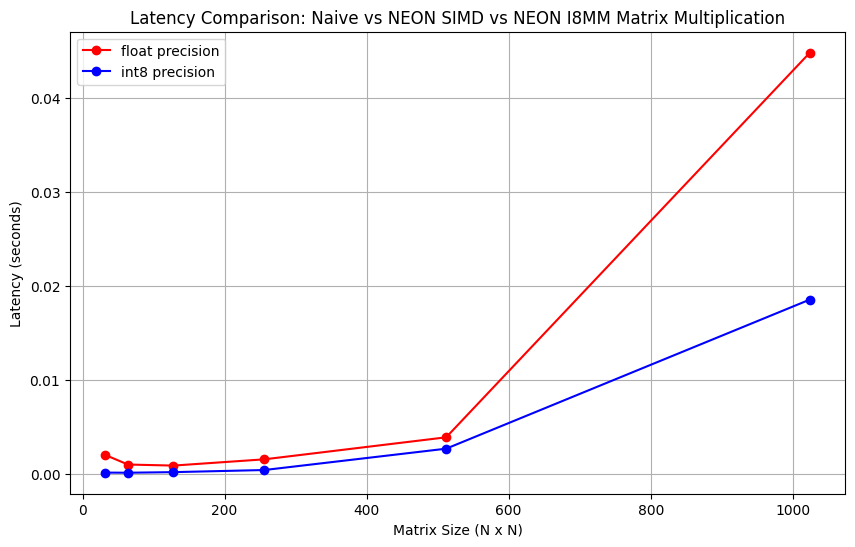

In [13]:
import matplotlib.pyplot as plt
import pandas as pd




plt.figure(figsize=(10, 6))

# Plotting the latency for each approach
plt.plot(sizes, float_times, marker='o', linestyle='-', color='r', label='float precision')
plt.plot(sizes, int8_times, marker='o', linestyle='-', color='b', label='int8 precision')
# Adding labels and title
plt.xlabel('Matrix Size (N x N)')
plt.ylabel('Latency (seconds)')
plt.title('Latency Comparison: Naive vs NEON SIMD vs NEON I8MM Matrix Multiplication')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


---
# **OpenELM**


### How to Download and Use Llama-3.2-1B from Hugging Face

1. **Log In or Sign Up**  
   If you don’t already have a Hugging Face account, create one. Otherwise, log in to your existing account.

2. **Visit the Model Page**  
   Navigate to the [apple/OpenELM](https://huggingface.co/apple/OpenELM) page on Hugging Face.

3. **Request Access**  
   On the model's page, click the **"Access repository"** button. You’ll be prompted to review and agree to the terms of use.

4. **Visit the Lamma Model Page**
   Navigate to the [meta-llama/Llama-2-7b-hf](https://huggingface.co/meta-llama/Llama-2-7b-hf) page on Hugging Face. You need to do this, as the OpenELM model uses the Lamma Tokenizer. 

5. **Request Access**  
   On the model's page, click the **"Access repository"** button. You’ll be prompted to review and agree to the terms of use.

6. **Wait for Approval**  
   After agreeing to the terms, access will be granted. This may take a few hours where you should receive a notificatino via email.

7. **Login via the Command Line**

To download the model, you may need to authenticate your Hugging Face account on your local machine. Run the following command in your terminal and follow the prompts to log in: (this will involve creating an access token for your local machine)

   ```bash
   huggingface-cli login
   ```

After this authentication, you can download and use the model with the following script.

**NOTE** This script may take up to half an hour to run the first time it is executed. This is because the Hugging Face package needs to download the model weights. After the initial execution, reloading the model should be faster (45s on RasberryPi 5) since Hugging Face caches the weights locally.

 


In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("apple/OpenELM-270M-Instruct", trust_remote_code=True)
model.eval()

A new version of the following files was downloaded from https://huggingface.co/apple/OpenELM-270M-Instruct:
- configuration_openelm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/apple/OpenELM-270M-Instruct:
- modeling_openelm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


OpenELMForCausalLM(
  (transformer): OpenELMModel(
    (token_embeddings): Embedding(32000, 1280)
    (layers): ModuleList(
      (0): OpenELMDecoderLayer(
        (attn): OpenELMMultiHeadCausalAttention(
          query_heads=12, key_heads=3, value_heads=3
          (qkv_proj): Linear(in_features=1280, out_features=1152, bias=False)
          (pos_embedding): OpenELMRotaryEmbedding(	model_dim=64, max_seq_length=4096, freq_constant=10000)
          (q_norm): OpenELMRMSNorm(num_features=64, eps=1e-06)
          (k_norm): OpenELMRMSNorm(num_features=64, eps=1e-06)
          (out_proj): Linear(in_features=768, out_features=1280, bias=False)
        )
        (ffn): OpenELMFeedForwardNetwork(
          (ffn_with_glu) : True
          (proj_1): Linear(in_features=1280, out_features=1536, bias=False)
          (proj_2): Linear(in_features=768, out_features=1280, bias=False)
          (act): SiLU()
        )
        (ffn_norm): OpenELMRMSNorm(num_features=1280, eps=1e-06)
        (attn_norm):

**Lets run a prompt through the model and see what it generates**
LLamma3.2-1B is a small base model trained to autoregressively generate a probability distribution over tokens based on the given input tokens. In this form, it functions as an autocomplete engine: given an initial prompt, the predicted next token can be appended to the original input and recursively passed through the model, creating a continuous sentence. However, this process requires the model to be forward-passed multiple times, increasing computational cost with longer sequences. To manage this, we'll set a maximum sequence length of 30 tokens and observe what the model generates as a completion to the prompt: ***ARM is a company that designs***

In [3]:
prompt = "ARM is a company that designs" 
inputs = tokenizer(prompt, return_tensors="pt")
outputs = model.generate(**inputs, max_length=20)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


ARM is a company that designs and manufactures microcontrollers, which are tiny electronic devices


**Lets measure the models static memory consumption** 

In [23]:
total_size = sum(p.numel() * p.element_size() for p in model.transformer.parameters())
buffer_size = sum(p.numel() * p.element_size() for p in model.transformer.buffers())
print(f"Total static memory usage: {(total_size + buffer_size) / (1024 ** 2)} MB")


Total static memory usage: 528.3544921875 MB


Wow, that's a significant amount of memory consumption—nearly 2GB! Many small embedded devices may struggle to handle this. Therefore, it's crucial to explore strategies for reducing the model's memory footprint, alongside improving inference speed. Doing so will expand the range of devices capable of running the model and, since memory access is energy-intensive, it will also reduce energy consumption and extend battery life. Next however, lets look at the latency bottlenecks and dynamic memory usage during inference with `torch.profiler`.

In [25]:
import torch
from torch.profiler import profile, ProfilerActivity, record_function
prompt = "ARM is a company that designs and develops microprocessors and other microchips. It is also known for its ARM Cortex processor and the ARM Mali GPU. ARM has been a leader in the mobile computing industry since the early 2000s, and is now a major player in the AI and "
inputs = tokenizer(prompt, return_tensors="pt")
# Profile the model
with profile(
    activities=[ProfilerActivity.CPU],
    record_shapes=True,
    with_stack=True,
    profile_memory=True,
) as prof:
    with record_function("model_inference"):
        with torch.no_grad():
            outputs = model(**inputs)

# Print a summary
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))


-----------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                 Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-----------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                      model_inference         3.94%     131.176ms       100.00%        3.330s        3.330s       3.45 Mb    -293.77 Mb             1  
                                         aten::linear         0.04%       1.345ms        78.99%        2.630s      32.469ms      73.23 Mb           0 b            81  
                                         aten::matmul         0.18%       6.131ms        78.86%        2.626s      32.414ms      73.23 Mb           0 b         

Your output should look something like this for OpenELM-450M

| **Name**                                      | Self CPU % | Self CPU   | CPU total % | CPU total   | CPU time avg  | CPU Mem      | Self CPU Mem | # of Calls |
|-----------------------------------------------|------------|------------|-------------|-------------|---------------|--------------|--------------|------------|
| model_inference                               | 3.04%      | 102.400ms  | 100.00%     | 3.368s      | 3.368s        | 19.99 Mb     | -277.23 Mb   | 1          |
| aten::linear                                  | 0.04%      | 1.397ms    | 84.72%      | 2.853s      | 35.228ms      | 73.23 Mb     | 0 b          | 81         |
| aten::matmul                                  | 0.22%      | 7.312ms    | 84.57%      | 2.848s      | 35.166ms      | 73.23 Mb     | 0 b          | 81         |
| aten::mm                                      | 84.26%     | 2.838s     | 84.26%      | 2.838s      | 35.040ms      | 73.23 Mb     | 73.23 Mb     | 81         |
| aten::mul                                     | 3.25%      | 109.364ms  | 3.26%       | 109.940ms   | 416.441us     | 101.71 Mb    | 101.71 Mb    | 264        |
| aten::add                                     | 1.40%      | 46.999ms   | 1.44%       | 48.336ms    | 300.221us     | 25.01 Mb     | 25.01 Mb     | 161        |
| aten::copy_                                   | 1.40%      | 46.988ms   | 1.40%       | 46.988ms    | 223.750us     | 0 b          | 0 b          | 210        |
| aten::pow                                     | 1.29%      | 43.434ms   | 1.30%       | 43.688ms    | 539.363us     | 25.29 Mb     | 25.29 Mb     | 81         |
| aten::mean                                    | 0.10%      | 3.447ms    | 1.20%       | 40.324ms    | 497.827us     | 139.50 Kb    | 139.49 Kb    | 81         |
| aten::scaled_dot_product_attention            | 0.02%      | 776.981us  | 1.07%       | 35.999ms    | 1.800ms       | 6.40 Mb      | -102.38 Kb   | 20         |

**Self CPU time total:** 3.368s

---

### Key Takeaways from Profiling

- **Matrix Multiplications (aten::mm)**: The dominant computational operation, accounting for 84% of the total CPU computation time. Dense layers (e.g., `aten::linear`) rely heavily on these operations.
- **Element-wise Operations**: `aten::mul` and `aten::add` are relatively minor contributors to overall performance, consuming ~4.7% of the computation time combined.
- **Memory Usage**: Matrix multiplications (`aten::mm`) are the most memory-intensive operation, allocating 73 MB. Dense layers similarly dominate memory usage.
- **Scaled Dot Product Attention**: This is relatively efficient, using only 6.40 MB and less than 1.1% of the total computation time.

---

### **Optimization Focus**

**Matrix multiplications in dense layers are the most critical operations to optimize.** These dominate both computation and memory usage, making them the primary target for performance improvements. Techniques such as vectorization and quantization, covered in earlier sections, can significantly enhance both efficiency and memory usage. Let's start by lowering the precision of the feedforward linear layers that rely heavily on matrix multiplications to the int8 datatype and see how this can speed up computation. This is a technique known as quantization. Specifically, we will start with a method called **Integer Symmetric Weight-Only Quantization**.
 


#### **Integer Per-TensorSymmetric Weight-Only Quantization**

Integer symmetric weight-only quantization reduces a neural network's weight precision from floating-point to integer values while keeping activations in floating-point format during inference. While the underlying matrix multiplication must still occur in floating point e.g. `torch.mm(W.dequantize(), x)`, the weight-only quantization can decrease the static memory consumption of the model by up to 4 times. Additionally in the case where the inference speed is limited by the memory bandwidth, reducing the weight precision can also reduce the memory read latencies, providing inference speedups. 

Given that the equation of the linear layer is

$y = XW + b$

To apply this technique, floating-point weights $ W $ are quantized to integer values $ Q_w $ using a scale factor $ S_w $. The scale factor can be computed based on the maximum absolute weight value:

$
S_w = \frac{\max(|W|)}{2^{b-1} - 1}
$

where $ b $ is the bit-width of the integer representation (e.g., $ b = 8 $ for 8-bit integers).

The quantization and dequantization processes are defined by:

- **Quantization**:
  $
  Q_w = \text{round}\left( \frac{W}{S_w} \right)
  $

- **Dequantization**:
  $
  \hat{W} = Q_w \cdot S_w
  $

During inference, the quantized weights $ Q_w $ are used with floating-point activations $ x $ to compute the output $ y $:

$
y = X \hat{W}  + b = X (Q_w \cdot S_w) + b
$

**Lets collect a weight matrix and activation tensor from one of the feed forward layers in the OpenELM Model.** (we can do this using a functionality of pytorch called forward hooks)






In [7]:
import torch
# Initialize dictionary to store activations
activations = {}

# Define a hook function to capture input
def get_activation_input(name):
    def hook(model, input, output):
        # 'input' is a tuple; we take the first element for the input tensor
        activations[name] = input[0]
    return hook

# Select the transformer block and register the hook
layer_idx = 15  # Select the transformer block of your choosing
layer = model.transformer.layers[layer_idx].ffn.proj_2
hook_handle = layer.register_forward_hook(get_activation_input('proj_2'))

# Run the model forward pass
with torch.no_grad():
    model(**inputs)

# Extract the weight matrix and the input activation tensor from the hook
W = layer.weight.data.clone()
X = activations['proj_2']
hook_handle.remove()

print(f"The collected weight matrix has shape {W.shape[0]}x{W.shape[1]} (output_channels x input_channels)")
print(f"The collected input activation tensor has shape {X.shape[0]}x{X.shape[1]}x{X.shape[2]} (batch_size x sequence_length x token_dim)")



The collected weight matrix has shape 1280x5120 (output_channels x input_channels)
The collected input activation tensor has shape 1x8x5120 (batch_size x sequence_length x token_dim)


Great!, now we have collected a weight matrix and activation tensor from the inside of the Lamma3.2-1B feed forward layers. We can now use these to test the accuracy of the quantization technique. Lets start by implementing the per-tensor quantization technque described above.

In [9]:
# Re-compute the output of the linear layer before quantization to compare against our quantized version. 
y = torch.matmul(X, W.t()) 

# Quantize the layer weight 'W'
b = 8  # Bit-width for quantization (int8 quantization)
S = W.abs().max() / (2**(b-1) - 1)  # Scale Factor Quantization
Q = torch.round(W / S).clamp(-2**(b-1), 2**(b-1) - 1)  # Quantizing the weights (clamp is used to prevent overflow)

# Weight-only quantized linear layer
y_hat = torch.matmul(X, (Q * S).t()) # Notice the Dequantzation step here (Q * S)

Let's check the quantization error to see if we have correctly approximated the full precision linear layer. This can be defined as the absolute difference between the full precision linear layer and our quantized version. Using our notation, where $y$ is the full precision output, $\hat{y}$ is the quantized output, $Q$ is the quantized tensor, and $S$ is the scale factor, the quantization error can be expressed as:

$$
\text{Quantization Error} = \left| y - \hat{y} \right| = \left| y - W \cdot (Q \cdot S) \right|
$$

Additionally, the relative quantization error as a percentage can be calculated to understand the error in relation to the magnitude of the full precision output:

$$
\text{Relative Quantization Error (\%)} = \left( \frac{\left| y - \hat{y} \right|}{\left| y \right|} \right) \times 100
$$

This relative error provides a normalized measure of the quantization error, making it easier to compare across different scales of output values.

In [10]:
# Calculate quantization error. This is the difference between the full precision linear layer and our quantized version. 
residuals = (y - y_hat).abs()
residuals_rel = (residuals / y.abs()) * 100
print(f"Max relative quantization error: {residuals_rel.max():.2f} (%)")
print(f"Min relative quantization error: {residuals_rel.min():.2f} (%)")
print(f"Mean relative quantization error: {residuals_rel.mean():.2f} (%)")


Max relative quantization error: 26829.35 (%)
Min relative quantization error: 0.00 (%)
Mean relative quantization error: 43.55 (%)


You should see that the mean and min relative quantization error are around 6% and 0% (for layer 8 of the Lamma3.2-1B model). The Max relative quantization error may however be huge. This is caused by outliers in the weight matrix distribution that skew the quantization error. There are anumber of techniques to mitigate this issue. We will not cover them here but you can learn more about them in the [LLM.int8() paper](https://arxiv.org/abs/2208.07339). 

This is a good start but we can quantize the weights, to give roughly a 5% relative quantization error. We however can do better. To do so lets try and understand what the distribution of the data in the weight matrix looks like. Below we will plot a boxplot of the 4 largest and 4 smallest channels in your chosen layer (set by the layer_idx variable). 

(5120, 10)


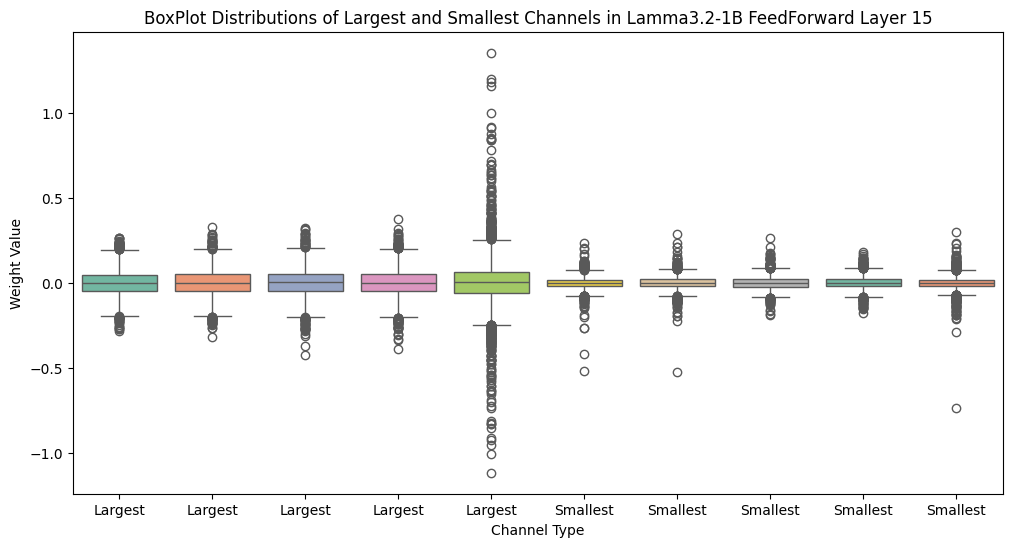

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the L2 norm of each channel along axis 1
channel_magnitudes = np.linalg.norm(W.clone().numpy(), axis=1)

num_channels_to_select = 5
largest_channels_indices = np.argsort(channel_magnitudes)[-num_channels_to_select:]
smallest_channels_indices = np.argsort(channel_magnitudes)[:num_channels_to_select]

# Select the largest and smallest channels along axis 1
largest_channels = W.numpy()[largest_channels_indices, :]
smallest_channels = W.numpy()[smallest_channels_indices, :]

# Combine the data for boxplot
combined_data = np.concatenate((largest_channels, smallest_channels), axis=0)
labels = ['Largest'] * num_channels_to_select + ['Smallest'] * num_channels_to_select

combined_data = combined_data.T
print(combined_data.shape)
# Plot boxplot for the selected channels
def plot_combined_boxplot(combined_data, labels):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=combined_data, palette="Set2")
    plt.xticks(ticks=np.arange(len(labels)), labels=labels * (combined_data.shape[1] // len(labels)))
    plt.title(f'BoxPlot Distributions of Largest and Smallest Channels in Lamma3.2-1B FeedForward Layer {layer_idx}')
    plt.xlabel('Channel Type')
    plt.ylabel('Weight Value')
    plt.show()

plot_combined_boxplot(combined_data, labels)

### Integer Per-Tensor Symmetric Weight-Only Quantization

Looking at this plot, what you can see is that the larger channels have very wide distributions and large outliers. Additionally, the small channels have very tight distributions centered around 0. If we used per-tensor quantization with just a single scale value $S_w$ for the entire tensor, all the values in the small channels would be mapped to zero, causing large quantization errors.

To overcome this, we can use a technique called **Per-Channel Weight-Only Quantization**. Instead of a single scale factor for the entire tensor, we compute a separate scale factor for each channel of the weight matrix. This allows us to more accurately quantize the weights in each channel, reducing the quantization error and preserving the accuracy of the model.

The process for doing this is as follows:

#### 1. Channel-Wise Scale Factor
For each channel $i$ of $\mathbf{W}$ (i.e., row $\mathbf{W}_i$), compute a channel-specific scale factor:

$
S_{w_i} = \frac{\max(|\mathbf{W}_i|)}{2^{b-1} - 1}.
$

#### 2. Channel-Wise Quantization and Dequantization
1. **Quantization**: Convert the weights of each channel to integer values:
   $
   Q_{w_i} = \text{round}\left(\frac{\mathbf{W}_i}{S_{w_i}}\right), \quad Q_{w_i} \in \{-2^{b-1}, \ldots, 2^{b-1} - 1\}.
   $

2. **Dequantization**: Recover the approximate floating-point weights of each channel:
   $
   \hat{\mathbf{W}}_i = Q_{w_i} \cdot S_{w_i}.
   $

The final quantized weight matrix $\hat{\mathbf{W}}$ is reconstructed by concatenating the channel-wise dequantized weights.

#### 3. Inference
During inference, the computation of $\mathbf{y}$ remains similar but uses the per-channel dequantized weights:

$
\mathbf{y} = \mathbf{x} \cdot \hat{\mathbf{W}} = \mathbf{x} \cdot \left(\sum_{i=1}^m Q_{w_i} \cdot S_{w_i}\right).
$

This approach ensures that both small and large channels are appropriately quantized, reducing overall quantization error. Lets implement this below. Your task is to complete the missing line in the code cell below that computs the per-channel scale factor. 


In [ ]:
# Re-compute the output of the linear layer before quantization. 
y = torch.matmul(X, W.t()) 

# Quantize the layer weight 'W'
b = 8  # Bit-width for quantization

# ------ Complete the missing line here ------
# you need to compute a different scale factor for each channel in the weight matrix. 
# this will result in a scale 'S' vector with the same number of output channels as the weight matrix. 
# S_per_channel = ... 
# ---------------------------------------------
Q = torch.round(W / S_per_channel).clamp(-2**(b-1), 2**(b-1) - 1)  # Q <- quantize(W)

# Weight-only quantized linear layer
y_hat_per_channel = torch.matmul(X, (Q * S_per_channel).t()) 

#### You can run this test below to check your implementation. 

In [13]:
from IPython.display import display, HTML

# Calculate quantization error
residuals_per_channel = (y - y_hat_per_channel).abs()
residuals_rel_per_channel = (residuals_per_channel / y.abs()) * 100
print(f"Max relative per channel quantization error: {residuals_rel_per_channel.max():.2f} (%), per-tensor quantization error: {residuals_rel.max():.2f} (%)")
print(f"Min relative per channel quantization error: {residuals_rel_per_channel.min():.2f} (%), per-tensor rel quantization error: {residuals_rel.min():.2f} (%)")
print(f"Mean relative per channel quantization error: {residuals_rel_per_channel.mean():.2f} (%), per-tensor mean rel quantization error: {residuals_rel.mean():.2f} (%)")

print(" ")

if residuals_rel_per_channel.mean() < residuals_rel.mean(): 
    display(HTML(f"<div style='color: green; font-size: 20px;'>Success! Per-Channel quantization error: {residuals_rel_per_channel.mean():.2f}% and Per-Tensor quantization error {residuals_rel.mean():.2f}%</div>"))
else: 
    display(HTML(f"<div style='color: red; font-size: 20px;'>Failed. Mean relative quantization error: {residuals_rel_per_channel.mean():.2f}%. Please try again.</div>"))

Max relative per channel quantization error: 5305.69 (%), per-tensor quantization error: 26829.35 (%)
Min relative per channel quantization error: 0.00 (%), per-tensor rel quantization error: 0.00 (%)
Mean relative per channel quantization error: 6.13 (%), per-tensor mean rel quantization error: 43.55 (%)
 


## SOLUTION ##

In [12]:
# Re-compute the output of the linear layer before quantization. 
y = torch.matmul(X, W.t()) 

# Quantize the layer weight 'W'
b = 8  # Bit-width for quantization

# ------ Complete the missing line here ------
# you need to compute a different scale factor for each channel in the weight matrix. 
# this will result in a scale 'S' vector with the same number of output channels as the weight matrix. 
S_per_channel = W.abs().max(dim=1, keepdim=True)[0] / (2**(b-1) - 1)  # Scale factor
# ---------------------------------------------
Q = torch.round(W / S_per_channel).clamp(-2**(b-1), 2**(b-1) - 1)  # Q <- quantize(W)

# Weight-only quantized linear layer
y_hat_per_channel = torch.matmul(X, (Q * S_per_channel).t()) 


Great! you should see that the per-channel weight only quantizaton technqiue has a significantly lower quantization error than per-tensor quantization. Lets now use this approach to quantize Lamma3.2-1B! Specifically we will apply the to the feedfoward layers of Lamma3.2-1B transformer blocks as they quantize the best. Lets build a class to achieve this. **Below is a simple implementation of the Per-ChannelWeight-Only Integer Quantization technique that can be applied to the pytorch linear layer. It however is not completed, you will therefore need to fill in the missing line in the `quantize` member function, aswell as the linear multiplication in the `forward` function**. 

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class WeightOnlyInt8Linear(nn.Module): 
    def __init__(self, in_features, out_features, bias=True): 
        super().__init__()
        self.in_features = in_features # number of input channels 
        self.out_features = out_features # number of output channels 
        self.scale = nn.Parameter(torch.ones(out_features), requires_grad=False)  # scale factor used for quantizing weights
        # Create a tensor with the desired dtype first, then wrap it with nn.Parameter
        self.weight = nn.Parameter(torch.empty(out_features, in_features, dtype=torch.int8), requires_grad=False)  # quantized weights
        if bias: 
            self.bias = nn.Parameter(torch.Tensor(out_features)) # bias term
        else: 
            self.register_parameter('bias', None)

    def quantize(self, tensor):
        b = 8
        qmin = -2**(b-1)
        qmax = 2**(b-1) - 1
        
        # ------ Complete the missing line here ------
        # you will need to compute a variable called `scale` that is used to quantize the `tensor` Look in the above exmple if you are unsure how to do this. 
        # scale = ...
        # ---------------------------------------------
        scale = scale.clamp(min=1e-8)
        quantized_weights = torch.round(tensor / scale).clamp(qmin, qmax)
        self.weight.data = quantized_weights 
        self.scale.data = scale
        return None

    def forward(self, x):
        # ------ Complete the missing line here ------
        # you will need to dequantize the weights `self.weight` using the scale factor `self.scale` and compute the output of the linear layer y. 
        # you can use the `torch.nn.functional.linear` function to perform the linear layer operation. (Remember to dequantize the weights first)
        # y = ...
        # ---------------------------------------------
        return y
    
    def __repr__(self): 
        return f"WeightOnlyInt8Linear(in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None})"


**You can test your implementation by running the following cell. The output relative error should be similar to the above example.** 

In [15]:
from IPython.display import display, HTML

# setup the full precision linear layer
linear = nn.Linear(W.shape[1], W.shape[0], bias=False)
linear.weight.data = W

# setup the quantized linear layer
qlinear = WeightOnlyInt8Linear(W.shape[1], W.shape[0], bias=False)
qlinear.quantize(W) 

# run the forward pass through the linear layer and compare the output to the full precision linear layer. 
y = linear(X)
y_hat = qlinear(X)

# Calculate relative quantization error
residuals = (y - y_hat).abs()
residuals_rel = (residuals / y.abs()) * 100
print(f"Max relative quantization error: {residuals_rel.max():.2f} (%)")
print(f"Min relative quantization error: {residuals_rel.min():.2f} (%)")
print(f"Mean relative quantization error: {residuals_rel.mean():.2f} (%)")

print(" ")

if residuals_rel.mean() < 8: 
    display(HTML(f"<div style='color: green; font-size: 20px;'>Success! Mean relative quantization error: {residuals_rel.mean():.2f}%</div>"))
else: 
    display(HTML(f"<div style='color: red; font-size: 20px;'>Failed. Mean relative quantization error: {residuals_rel.mean():.2f}%. Please try again.</div>"))





Max relative quantization error: 5305.69 (%)
Min relative quantization error: 0.00 (%)
Mean relative quantization error: 6.13 (%)
 


***SOLUTION***

In [14]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F

class WeightOnlyInt8Linear(nn.Module): 
    def __init__(self, in_features, out_features, bias=True): 
        super().__init__()
        self.in_features = in_features # number of input channels 
        self.out_features = out_features # number of output channels 
        self.scale = nn.Parameter(torch.ones(1, dtype=torch.float32), requires_grad=False)  # scale factor used for quantizing weights
        # Create a tensor with the desired dtype first, then wrap it with nn.Parameter
        self.weight = nn.Parameter(torch.empty(out_features, in_features, dtype=torch.int8), requires_grad=False)  # quantized weights
        if bias: 
            self.bias = nn.Parameter(torch.Tensor(out_features)) # bias term
        else: 
            self.register_parameter('bias', None)

    def quantize(self, tensor):
        b = 8
        qmin = -2**(b-1)
        qmax = 2**(b-1) - 1
        
        # ------ Complete the missing line here ------
        # you will need to compute a variable called `scale` that is used to quantize the `tensor` Look in the above exmple if you are unsure how to do this. 
        scale = torch.Tensor((tensor.abs().max(dim=1, keepdims=True)[0] / qmax))
        # ---------------------------------------------
        scale = scale.clamp(min=1e-8)
        quantized_weights = torch.round(tensor / scale).clamp(qmin, qmax)
        quantized_weights = quantized_weights.type(torch.int8)
        self.weight.data = quantized_weights 
        self.scale.data = scale
        assert self.weight.dtype == torch.int8
        return None

    def forward(self, x):
        # ------ Complete the missing line here ------
        # you will need to dequantize the weights `self.weight` using the scale factor `self.scale` and compute the output of the linear layer y. 
        # you can use the `torch.nn.functional.linear` function to perform the linear layer operation. 
        y = F.linear(x, self.weight * self.scale, self.bias)
        # ---------------------------------------------
        return y
    
    def __repr__(self): 
        return f"WeightOnlyInt8Linear(in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None})"


**Lets now use this to quantize the feedforward layers of Lamma3.2-1B.**


In [30]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("apple/OpenELM-270M-Instruct", trust_remote_code=True)
model.eval()

def quantize_model(model):
    for layer_idx, block in enumerate(model.transformer.layers):
        print(f"Quantizing layer {layer_idx}...")
        for name, module in block.ffn.named_modules():
            if isinstance(module, nn.Linear):
                qlinear = WeightOnlyInt8Linear(module.in_features, module.out_features, bias=module.bias is not None)
                if module.bias is not None:
                    qlinear.bias.data = module.bias.data
                qlinear.quantize(module.weight.data.clone())
                
                # Replace the module with quantized layer
                parent_module = block.ffn
                setattr(parent_module, name, qlinear)
                

quantize_model_incrementally(model)
model

Quantizing layer 0...
Quantizing layer 1...
Quantizing layer 2...
Quantizing layer 3...
Quantizing layer 4...
Quantizing layer 5...
Quantizing layer 6...
Quantizing layer 7...
Quantizing layer 8...
Quantizing layer 9...
Quantizing layer 10...
Quantizing layer 11...
Quantizing layer 12...
Quantizing layer 13...
Quantizing layer 14...
Quantizing layer 15...


OpenELMForCausalLM(
  (transformer): OpenELMModel(
    (token_embeddings): Embedding(32000, 1280)
    (layers): ModuleList(
      (0): OpenELMDecoderLayer(
        (attn): OpenELMMultiHeadCausalAttention(
          query_heads=12, key_heads=3, value_heads=3
          (qkv_proj): Linear(in_features=1280, out_features=1152, bias=False)
          (pos_embedding): OpenELMRotaryEmbedding(	model_dim=64, max_seq_length=4096, freq_constant=10000)
          (q_norm): OpenELMRMSNorm(num_features=64, eps=1e-06)
          (k_norm): OpenELMRMSNorm(num_features=64, eps=1e-06)
          (out_proj): Linear(in_features=768, out_features=1280, bias=False)
        )
        (ffn): OpenELMFeedForwardNetwork(
          (ffn_with_glu) : True
          (proj_1): WeightOnlyInt8Linear(in_features=1280, out_features=1536, bias=False)
          (proj_2): WeightOnlyInt8Linear(in_features=768, out_features=1280, bias=False)
          (act): SiLU()
        )
        (ffn_norm): OpenELMRMSNorm(num_features=1280, eps

**Now lets run a prompt through the model and make sure we haven't broken anything.**

In [19]:
prompt = "ARM is a company that designs" 
inputs = tokenizer(prompt, return_tensors="pt")
outputs = model.generate(**inputs, max_length=50)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


ARM is a company that designs and manufactures microcontrollers, which are tiny electronic devices that can perform specific functions. The company has a long history of developing ARM-based devices, including the Cortex-A9 CPU, the


Great, now we have confirmed that. Lets check the static memory consumption, to see what benefits weight only quantization has brought us. 

In [22]:
total_size = sum(p.numel() * p.element_size() for p in model.transformer.parameters())
buffer_size = sum(p.numel() * p.element_size() for p in model.transformer.buffers())
print(f"Total static memory usage: {(total_size + buffer_size) / (1024 ** 2)} MB")

Total static memory usage: 528.3544921875 MB


Great. So we have reduced the static memory consumption from 4.7Gb to 2.3Gb. This is a significant reduction, and will make the model more portable to smaller devices. We can however do better. Lets explore graph optimization techniques to improve the inference speed. 

# Overview of `torch.compile` for ARM CPUs in PyTorch

`torch.compile` is a feature in PyTorch that optimizes model execution by compiling models into more efficient forms, specifically tailored for ARM CPUs. This process reduces the overhead of PyTorch's dynamic execution, leading to faster execution times and lower resource usage on ARM architectures. By analyzing the model's computation graph, `torch.compile` applies optimizations such as operator fusion and loop unrolling, which are particularly beneficial for ARM's architecture.

ARM CPUs are known for their energy efficiency and performance, making them ideal for deploying AI models in diverse environments. `torch.compile` leverages ARM's specific capabilities, including its support for SIMD (Single Instruction, Multiple Data) instructions like NEON, to enhance model performance. This allows for parallel processing of multiple data points, significantly accelerating computationally intensive tasks.

The feature is user-friendly, requiring minimal changes to existing code. Users can compile their models with `torch.compile` and immediately benefit from performance improvements on ARM CPUs. This makes it particularly useful for complex models or those running on ARM-based devices, offering significant speedups and efficiency gains.

In [24]:
def benchmark_latency(inputs, model, num_runs=10):
    import time
    import torch

    # Ensure the model is in evaluation mode
    model.eval()

    # Warm-up runs (to stabilize any initial overhead)
    with torch.no_grad():
        for _ in range(10):
            model(**inputs)

    # Measure latency
    times = []
    with torch.no_grad():
        for _ in range(num_runs):
            start_time = time.time()
            model(**inputs)
            end_time = time.time()
            times.append((end_time - start_time) * 1000)  # Convert to milliseconds

    # Calculate average latency
    avg_latency = sum(times) / len(times)
    return avg_latency


lat = benchmark_latency(inputs, model)
print(f"Average latency for Eager Execution: {lat:.2f} ms")

Average latency for Eager Execution: 135.83 ms


In [25]:
import os
import torch 
os.environ["TOKENIZERS_PARALLELISM"] = "false"
compiled_model = torch.compile(model)
lat = benchmark_latency(inputs, compiled_model)
print(f"Average latency for Torch Compile: {lat:.2f} ms")

Average latency for Torch Compile: 97.60 ms


# Exporting the model for embedded inference. 